## Imports

In [215]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import chi2_contingency

from sklearn.cluster import KMeans
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder


## Get raw prosecution data

In [217]:
prosecution = pd.read_csv("./base_data/Hate-Prosecution-survey-2004-2020.csv")
prosecution.head()


,Year,Agency Type,Agency Name,Total Hate Crime Cases Referred,Total Cases Filed as Hate Crimes,Total Cases Filed as Non-Bias Motivated Crimes,Total Dispositions,Not Convicted,Total Convictions,Total Hate Crime Convictions,Guilty plea/Nolo contendere,Trial Verdict,All Other Convictions
0,2004,County DA,Alameda,2,2,0,2,1,1,1,1,0,0
1,2004,County DA,Alpine,0,0,0,0,0,0,0,0,0,0
2,2004,County DA,Amador,1,1,0,1,0,1,0,0,0,1
3,2004,County DA,Butte,8,8,2,7,1,6,2,1,1,4
4,2004,County DA,Calaveras,0,0,0,0,0,0,0,0,0,0


In [218]:
prosecution.dtypes


Year                                               int64
Agency Type                                       object
Agency Name                                       object
Total Hate Crime Cases Referred                   object
Total Cases Filed as Hate Crimes                  object
Total Cases Filed as Non-Bias Motivated Crimes    object
Total Dispositions                                object
Not Convicted                                     object
Total Convictions                                 object
Total Hate Crime Convictions                      object
Guilty plea/Nolo contendere                       object
Trial Verdict                                     object
All Other Convictions                             object
dtype: object

## Convert relevant columns to ints

In [219]:
# Columns to convert
int_cols = [
    "Total Hate Crime Cases Referred",
    "Total Cases Filed as Hate Crimes",
    "Total Cases Filed as Non-Bias Motivated Crimes",
    "Total Dispositions",
    "Not Convicted",
    "Total Convictions",
    "Total Hate Crime Convictions",
    "Guilty plea/Nolo contendere",
    "Trial Verdict",
    "All Other Convictions",
]


In [220]:
for col in int_cols:
    # Change rows with "-" to 0
    prosecution[col] = prosecution[col].str.replace("-", "0")
    # Fill NaNs with 0
    prosecution[col].fillna(0, inplace=True)
    # Change dtype to int
    prosecution[col] = prosecution[col].astype(int)


In [221]:
# Sanity Check
prosecution.dtypes


Year                                               int64
Agency Type                                       object
Agency Name                                       object
Total Hate Crime Cases Referred                    int64
Total Cases Filed as Hate Crimes                   int64
Total Cases Filed as Non-Bias Motivated Crimes     int64
Total Dispositions                                 int64
Not Convicted                                      int64
Total Convictions                                  int64
Total Hate Crime Convictions                       int64
Guilty plea/Nolo contendere                        int64
Trial Verdict                                      int64
All Other Convictions                              int64
dtype: object

## Group data by Agency Name (county) and aggregate for all years

In [222]:
# Look at Agency Name, mostly counties
prosecution["Agency Name"].unique()


array(['Alameda', 'Alpine', 'Amador', 'Butte', 'Calaveras', 'Colusa',
       'Contra Costa', 'Del Norte', 'El Dorado', 'Fresno', 'Glenn',
       'Humboldt', 'Imperial', 'Inyo', 'Kern', 'Kings', 'Lake', 'Lassen',
       'Los Angeles', 'Madera', 'Marin', 'Mariposa', 'Mendocino',
       'Merced', 'Modoc', 'Mono', 'Monterey', 'Napa', 'Nevada', 'Orange',
       'Placer', 'Plumas', 'Riverside', 'Sacramento', 'San Benito',
       'San Bernardino', 'San Diego', 'San Francisco', 'San Joaquin',
       'San Luis Obispo', 'San Mateo', 'Santa Barbara', 'Santa Clara',
       'Santa Cruz', 'Shasta', 'Sierra', 'Siskiyou', 'Solano', 'Sonoma',
       'Stanislaus', 'Sutter', 'Tehama', 'Trinity', 'Tulare', 'Tuolumne',
       'Ventura', 'Yolo', 'Yuba', 'Anaheim', 'Burbank', 'Inglewood',
       'Long Beach', 'Pasadena', 'Torrance', 'Chula Vista', 'Compton',
       'Huntington Beach', 'Oakland', 'Redondo Beach', 'San Rafael',
       'ContraCosta', 'DelNorte', 'ElDorado', 'LosAngeles', 'SanBenito',
       'Sa

In [223]:
prosecution["Agency Type"].unique()


array(['County DA', 'Elected City Attorney'], dtype=object)

In [224]:
# Strip spaces in some counties
prosecution["Agency Name"] = prosecution["Agency Name"].str.replace(" ", "")
prosecution["Agency Name"].unique()


array(['Alameda', 'Alpine', 'Amador', 'Butte', 'Calaveras', 'Colusa',
       'ContraCosta', 'DelNorte', 'ElDorado', 'Fresno', 'Glenn',
       'Humboldt', 'Imperial', 'Inyo', 'Kern', 'Kings', 'Lake', 'Lassen',
       'LosAngeles', 'Madera', 'Marin', 'Mariposa', 'Mendocino', 'Merced',
       'Modoc', 'Mono', 'Monterey', 'Napa', 'Nevada', 'Orange', 'Placer',
       'Plumas', 'Riverside', 'Sacramento', 'SanBenito', 'SanBernardino',
       'SanDiego', 'SanFrancisco', 'SanJoaquin', 'SanLuisObispo',
       'SanMateo', 'SantaBarbara', 'SantaClara', 'SantaCruz', 'Shasta',
       'Sierra', 'Siskiyou', 'Solano', 'Sonoma', 'Stanislaus', 'Sutter',
       'Tehama', 'Trinity', 'Tulare', 'Tuolumne', 'Ventura', 'Yolo',
       'Yuba', 'Anaheim', 'Burbank', 'Inglewood', 'LongBeach', 'Pasadena',
       'Torrance', 'ChulaVista', 'Compton', 'HuntingtonBeach', 'Oakland',
       'RedondoBeach', 'SanRafael'], dtype=object)

In [225]:
# Drop Elected City Attorneys
prosecution = prosecution[prosecution["Agency Type"] == "County DA"]
prosecution["Agency Type"].unique()


array(['County DA'], dtype=object)

In [226]:
# Groupby and aggregate (sum)
prosecution_all_years = prosecution.drop(columns="Year").groupby(by="Agency Name").sum()
prosecution_all_years.reset_index(inplace=True)


## Visualize counties by number of hate crimes referred

In [227]:
# See counties with most Hate Crimes
prosecution_all_years.sort_values(
    by="Total Hate Crime Cases Referred", ascending=False
).head(20)


,Agency Name,Total Hate Crime Cases Referred,Total Cases Filed as Hate Crimes,Total Cases Filed as Non-Bias Motivated Crimes,Total Dispositions,Not Convicted,Total Convictions,Total Hate Crime Convictions,Guilty plea/Nolo contendere,Trial Verdict,All Other Convictions
18,LosAngeles,1871,1337,176,954,144,810,457,269,188,353
36,SanDiego,444,295,79,259,5,254,150,144,6,104
37,SanFrancisco,403,235,57,141,20,121,76,66,10,45
29,Orange,371,195,73,191,8,183,152,147,5,31
32,Riverside,335,176,103,179,4,175,94,83,11,81
42,SantaClara,274,127,74,70,3,67,48,47,1,19
55,Ventura,179,117,36,70,4,66,56,45,11,10
0,Alameda,167,116,2,86,11,75,24,24,0,51
33,Sacramento,141,74,26,52,1,51,30,28,2,21
44,Shasta,123,91,27,68,15,53,22,22,0,31


''

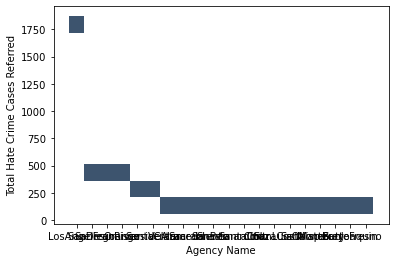

In [228]:
# Visualize top 20 counties
sns.histplot(
    prosecution_all_years.sort_values(
        by="Total Hate Crime Cases Referred", ascending=False
    ).head(20),
    x="Agency Name",
    y="Total Hate Crime Cases Referred",
)
;


## Save Clean Prosecution Data
Aggregated by Year

In [229]:
prosecution_all_years.to_csv("./data/prosecution_all_years.csv", index=False)


## Create Prosecution Rate column
This will be our target

In [230]:
prosecution_all_years["prosecution-rate"] = prosecution_all_years[
    "Total Dispositions"
].astype(int) / prosecution_all_years["Total Hate Crime Cases Referred"].astype(int)


## Visualize Prosecution Rates

In [231]:
prosecution_all_years.sort_values(by="prosecution-rate", ascending=False).head(20)


,Agency Name,Total Hate Crime Cases Referred,Total Cases Filed as Hate Crimes,Total Cases Filed as Non-Bias Motivated Crimes,Total Dispositions,Not Convicted,Total Convictions,Total Hate Crime Convictions,Guilty plea/Nolo contendere,Trial Verdict,All Other Convictions,prosecution-rate
14,Kern,43,77,7,64,3,61,19,19,0,42,1.488372
10,Glenn,7,7,0,10,0,10,5,5,0,5,1.428571
13,Inyo,11,8,2,12,0,12,4,4,0,8,1.090909
4,Calaveras,4,4,0,4,1,3,0,0,0,3,1.000000
6,ContraCosta,85,80,12,75,25,50,15,14,1,35,0.882353
54,Tuolumne,7,4,0,6,0,6,5,5,0,1,0.857143
2,Amador,5,5,0,4,0,4,2,2,0,2,0.800000
50,Sutter,5,3,1,4,0,4,1,1,0,3,0.800000
9,Fresno,56,51,10,39,5,34,16,13,3,18,0.696429
35,SanBernardino,118,98,7,79,7,72,14,14,0,58,0.669492


''

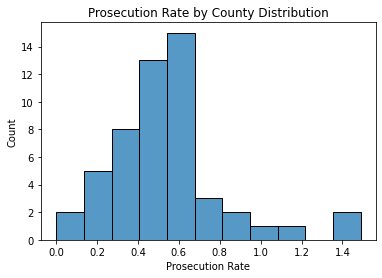

In [232]:
sns.histplot(prosecution_all_years["prosecution-rate"])
plt.title('Prosecution Rate by County Distribution')
plt.xlabel('Prosecution Rate')
plt.savefig('./figures/prosecution-rate-hist.png')
;


These look normally distributed

## Create Target variable by mapping prosecution rates to three categories
0 - Prosecution not likely

1 - Prosecution likely

2 - Prosecution very likely

In [233]:
# Check distribution for mapping
prosecution_all_years["prosecution-rate"].describe()


count    52.000000
mean      0.549941
std       0.282699
min       0.000000
25%       0.390518
50%       0.531315
75%       0.652174
max       1.488372
Name: prosecution-rate, dtype: float64

In [234]:
# With help from https://stackoverflow.com/questions/33439434/multiple-if-statements-in-a-lambda-function
prosecution_all_years["labels"] = prosecution_all_years["prosecution-rate"].map(
    lambda x: 0
    if x < prosecution_all_years["prosecution-rate"].describe()["25%"]
    else 1
    if x < prosecution_all_years["prosecution-rate"].describe()["75%"]
    else 2
)


In [235]:
prosecution_all_years["labels"].value_counts()


1    24
2    21
0    13
Name: labels, dtype: int64

## Save Target DataFrames to add to hate crimes data later

In [236]:
prosecution_labels = prosecution_all_years[["Agency Name", "labels"]]


In [237]:
prosecution_rates = prosecution_all_years[["Agency Name", "prosecution-rate"]]


## Import Hate Crimes Data cleaned by Courtney

In [241]:
full_data = pd.read_csv("./data/cleaned_hate_crimes.csv", index_col=0)
full_data.columns


Index(['ClosedYear', 'MonthOccurrence', 'County', 'NCIC',
       'TotalNumberOfVictims', 'TotalNumberOfIndividualVictims',
       'SuspectsRaceAsAGroup', 'TotalNumberOfSuspects', 'MostSeriousUcr',
       'MostSeriousUcrType', 'MostSeriousLocation', 'MostSeriousBias',
       'MostSeriousBiasType', 'MostSeriousVictimType', 'WeaponType',
       'Offensive_Act'],
      dtype='object')

### Clean County Names

In [243]:
# Check for County vs. Agency Name compatibility
full_data['County'].unique()

array(['Alameda', 'Butte', 'ContraCosta', 'DelNorte', 'Fresno',
       'Humboldt', 'Imperial', 'Kern', 'Lake', 'LosAngeles', 'Madera',
       'Marin', 'Mariposa', 'Mendocino', 'Merced', 'Mono', 'Monterey',
       'Napa', 'Nevada', 'Orange', 'Placer', 'Riverside', 'Sacramento',
       'SanBernardino', 'SanDiego', 'SanFrancisco', 'SanJoaquin',
       'SanLuisObispo', 'SanMateo', 'SantaBarbara', 'SantaClara',
       'SantaCruz', 'Shasta', 'Solano', 'Sonoma', 'Stanislaus', 'Sutter',
       'Tehama', 'Tuolumne', 'Ventura', 'Yolo', 'Yuba', 'Calaveras',
       'ElDorado', 'Kings', 'Modoc', 'Siskiyou', 'Trinity', 'Plumas',
       'SanBenito', 'Tulare', 'Amador', 'Lassen', 'Inyo', 'Colusa',
       'Glenn', 'Alpine'], dtype=object)

In [244]:
# Strip spaces from County in full_data
full_data["County"] = full_data["County"].str.replace(" ", "")
full_data["County"].unique()


array(['Alameda', 'Butte', 'ContraCosta', 'DelNorte', 'Fresno',
       'Humboldt', 'Imperial', 'Kern', 'Lake', 'LosAngeles', 'Madera',
       'Marin', 'Mariposa', 'Mendocino', 'Merced', 'Mono', 'Monterey',
       'Napa', 'Nevada', 'Orange', 'Placer', 'Riverside', 'Sacramento',
       'SanBernardino', 'SanDiego', 'SanFrancisco', 'SanJoaquin',
       'SanLuisObispo', 'SanMateo', 'SantaBarbara', 'SantaClara',
       'SantaCruz', 'Shasta', 'Solano', 'Sonoma', 'Stanislaus', 'Sutter',
       'Tehama', 'Tuolumne', 'Ventura', 'Yolo', 'Yuba', 'Calaveras',
       'ElDorado', 'Kings', 'Modoc', 'Siskiyou', 'Trinity', 'Plumas',
       'SanBenito', 'Tulare', 'Amador', 'Lassen', 'Inyo', 'Colusa',
       'Glenn', 'Alpine'], dtype=object)

## Merge Prosecution and Hate Crime DataFrames

### Prosecution Labels

In [245]:
# Merge
modeling_data = full_data.merge(
    prosecution_labels, left_on="County", right_on="Agency Name"
)


In [246]:
# Sanity Check
modeling_data["labels"].value_counts()


1    17800
0     4123
2     2513
Name: labels, dtype: int64

In [247]:
# Sanity Check
modeling_data.shape


(24436, 18)

#### Save for Data Viz

In [248]:
modeling_data.to_csv('./data/hc_vis.csv')

### Drop

In [199]:
# Drop columns that won't be used in modeling
modeling_data.drop(
    columns=["RecordId", "ClosedYear", "County", "NCIC", "Agency Name"], inplace=True
)


### Prosecution Rates

In [200]:
# Merge
modeling_data2 = full_data.merge(
    prosecution_rates, left_on="County", right_on="Agency Name"
)


In [201]:
# Check for NaNs
modeling_data2["prosecution-rate"].isna().sum()


20

In [202]:
# Drop NaNs
modeling_data2.dropna(inplace=True)


In [203]:
# Sanity
modeling_data2.shape

(19005, 19)

In [204]:
# Drop columns that won't be used in modeling
modeling_data2.drop(
    columns=["RecordId", "ClosedYear", "County", "NCIC", "Agency Name"], inplace=True
)


## Save Modeling Data

In [205]:
modeling_data.to_csv("./data/classification_data.csv", index=False)


In [206]:
modeling_data2.to_csv("./data/regression_data.csv", index=False)


## Pairplots
Why not?

''

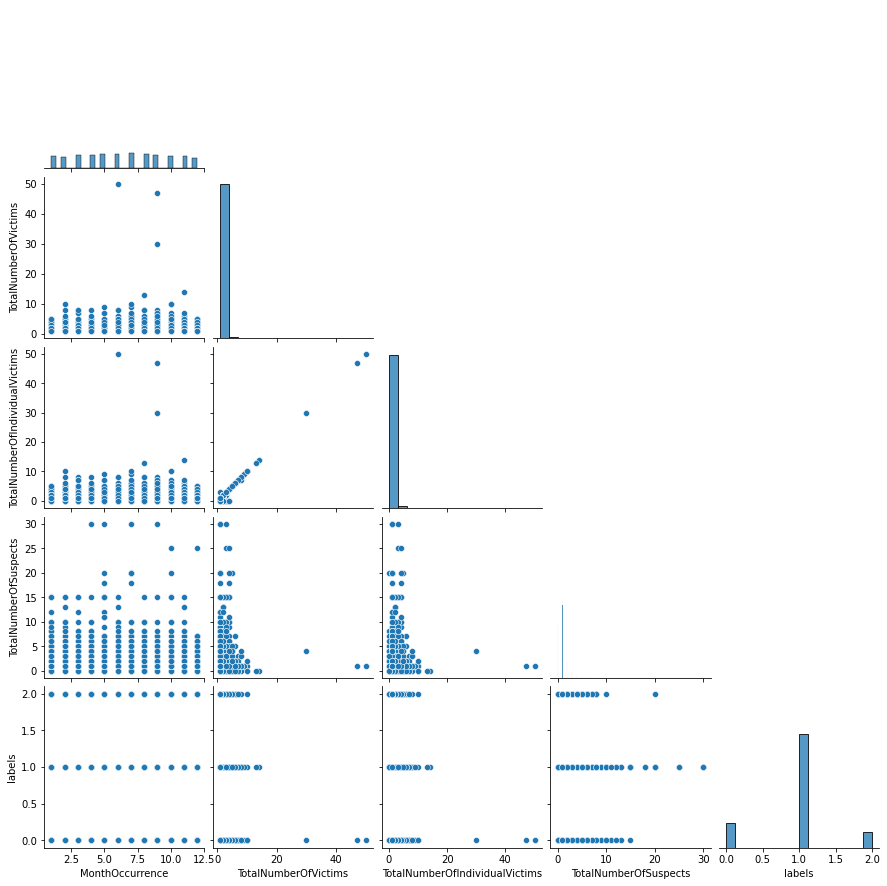

In [207]:
sns.pairplot(modeling_data, corner=True)
;

''

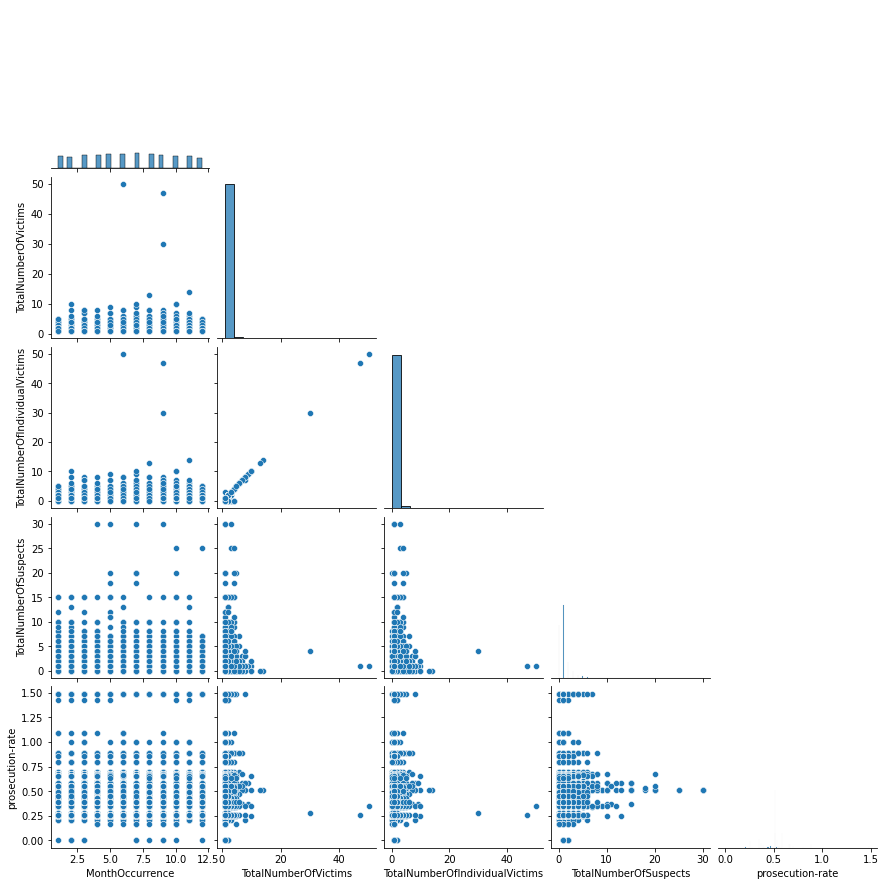

In [208]:
sns.pairplot(modeling_data2, corner=True)
;